In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
from torch.nn.functional import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report ,accuracy_score
import seaborn as sns
import random
import torch.nn.functional as F


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
BATCH_SIZE = 32
NUM_CLASSES = 2  
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
VALIDATION_SPLIT = 0.2

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transform)

def filter_dataset(dataset, class_map):
    indices = [idx for idx, label in enumerate(dataset.targets) if label in class_map]
    dataset.data = dataset.data[indices]
    dataset.targets = [class_map[label] for label in dataset.targets if label in class_map]
    return dataset

class_mapping = {0: 0, 1: 1}  
train_dataset = filter_dataset(train_dataset, class_mapping)
test_dataset = filter_dataset(test_dataset, class_mapping)

train_size = int((1 - VALIDATION_SPLIT) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Train set size: 8000
Validation set size: 2000
Test set size: 2000


In [28]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_accuracy = 0.0 
    best_model_path = "best_model.pth"  

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation accuracy: {best_val_accuracy:.2f}%")

        print(
            f"Epoch [{epoch+1}/{num_epochs}]: "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%"
        )

    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}% (Model saved to {best_model_path})")
    return train_losses, train_accuracies, val_losses, val_accuracies

Best model saved with validation accuracy: 96.50%
Epoch [1/10]: Train Loss: 0.2249, Train Accuracy: 91.44% Validation Loss: 0.0944, Validation Accuracy: 96.50%
Epoch [2/10]: Train Loss: 0.0930, Train Accuracy: 96.86% Validation Loss: 0.1459, Validation Accuracy: 94.60%
Epoch [3/10]: Train Loss: 0.0752, Train Accuracy: 97.31% Validation Loss: 0.0987, Validation Accuracy: 96.05%
Best model saved with validation accuracy: 97.45%
Epoch [4/10]: Train Loss: 0.0814, Train Accuracy: 96.91% Validation Loss: 0.0755, Validation Accuracy: 97.45%
Epoch [5/10]: Train Loss: 0.0680, Train Accuracy: 97.74% Validation Loss: 0.1036, Validation Accuracy: 96.15%
Epoch [6/10]: Train Loss: 0.0476, Train Accuracy: 98.38% Validation Loss: 0.0814, Validation Accuracy: 97.10%
Epoch [7/10]: Train Loss: 0.0391, Train Accuracy: 98.62% Validation Loss: 0.0936, Validation Accuracy: 96.35%
Epoch [8/10]: Train Loss: 0.0347, Train Accuracy: 98.79% Validation Loss: 0.0794, Validation Accuracy: 96.75%
Epoch [9/10]: Train 

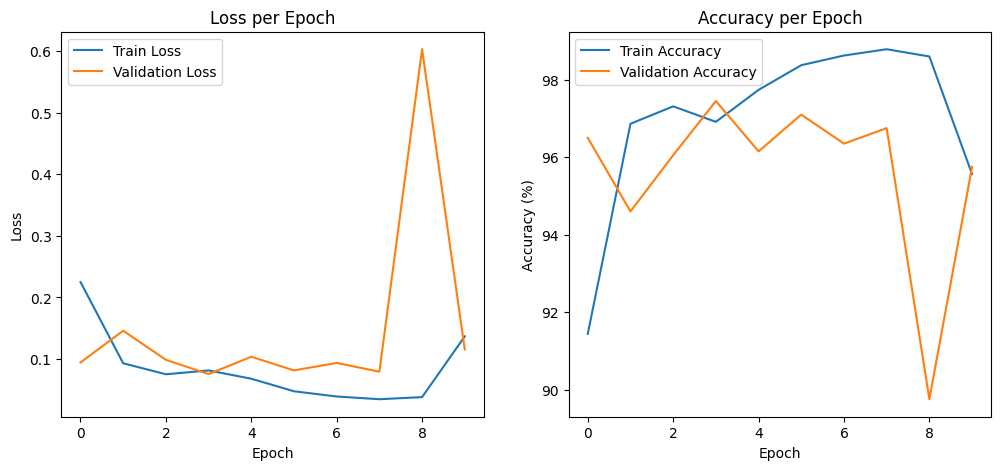

In [29]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

In [8]:
def get_sample_images(dataset, class_map):
    """
    Collect a single sample image for each class from the dataset.
    """
    samples = {}
    for image, label in dataset:
        if label not in samples:
            samples[label] = image.unsqueeze(0)  
        if len(samples) == len(class_map):
            break
    return samples

def visualize_feature_maps(model, layers_to_visualize, input_image, device='cuda'):
    """
    Visualize feature maps for specified layers in a model.
    """
    model = model.to(device)
    input_image = input_image.to(device)

    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    img = input_image[0].cpu().permute(1, 2, 0).numpy()  
    img = (img * 0.5 + 0.5).clip(0, 1)  
    ax.imshow(img)
    ax.set_title("Input Image")
    ax.axis("off")
    plt.show()

    feature_maps = {}

    def register_hooks(layer_names):
        hooks = []

        def hook_fn(name):
            def hook(module, input, output):
                feature_maps[name] = output
            return hook

        for name, module in model.named_modules():
            if name in layer_names:
                hooks.append(module.register_forward_hook(hook_fn(name)))

        return hooks

    hooks = register_hooks(layers_to_visualize)

    model.eval()
    with torch.no_grad():
        model(input_image)

    for hook in hooks:
        hook.remove()

    for layer_name in layers_to_visualize:
        if layer_name in feature_maps:
            fmap = feature_maps[layer_name][0]  
            num_features = fmap.size(0)  

            grid_cols = int(num_features**0.5) + 1
            grid_rows = int(num_features / grid_cols) + 1

            fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 12))
            axes = axes.flatten()
            for i in range(num_features):
                axes[i].imshow(fmap[i].cpu().numpy(), cmap='viridis')
                axes[i].axis('off')

            for i in range(num_features, len(axes)):
                axes[i].axis('off')

            plt.suptitle(f"Feature Maps - {layer_name}", fontsize=16)
            plt.show()


/tmp/ipykernel_23/2198664569.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 96.55%


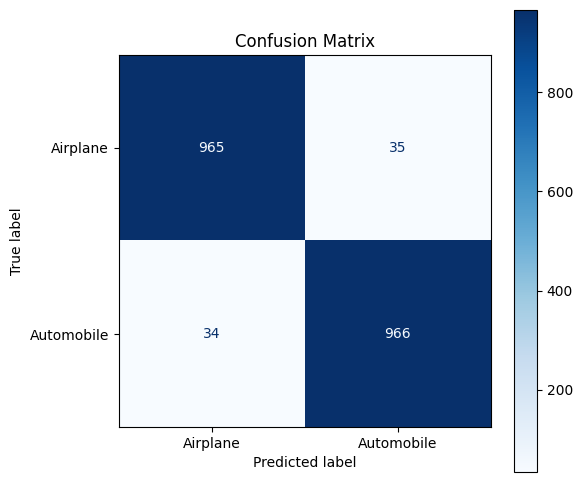

In [30]:
def evaluate_model(model, test_loader, device='cuda'):
    """
    Evaluate the model on the test dataset and compute predictions and true labels.
    """
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a confusion matrix using sklearn's ConfusionMatrixDisplay.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)

class_names = ["Airplane", "Automobile"]  
predictions, true_labels = evaluate_model(model, test_loader, device)

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

plot_confusion_matrix(true_labels, predictions, class_names)

Visualizing feature maps for class: Automobile


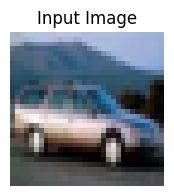

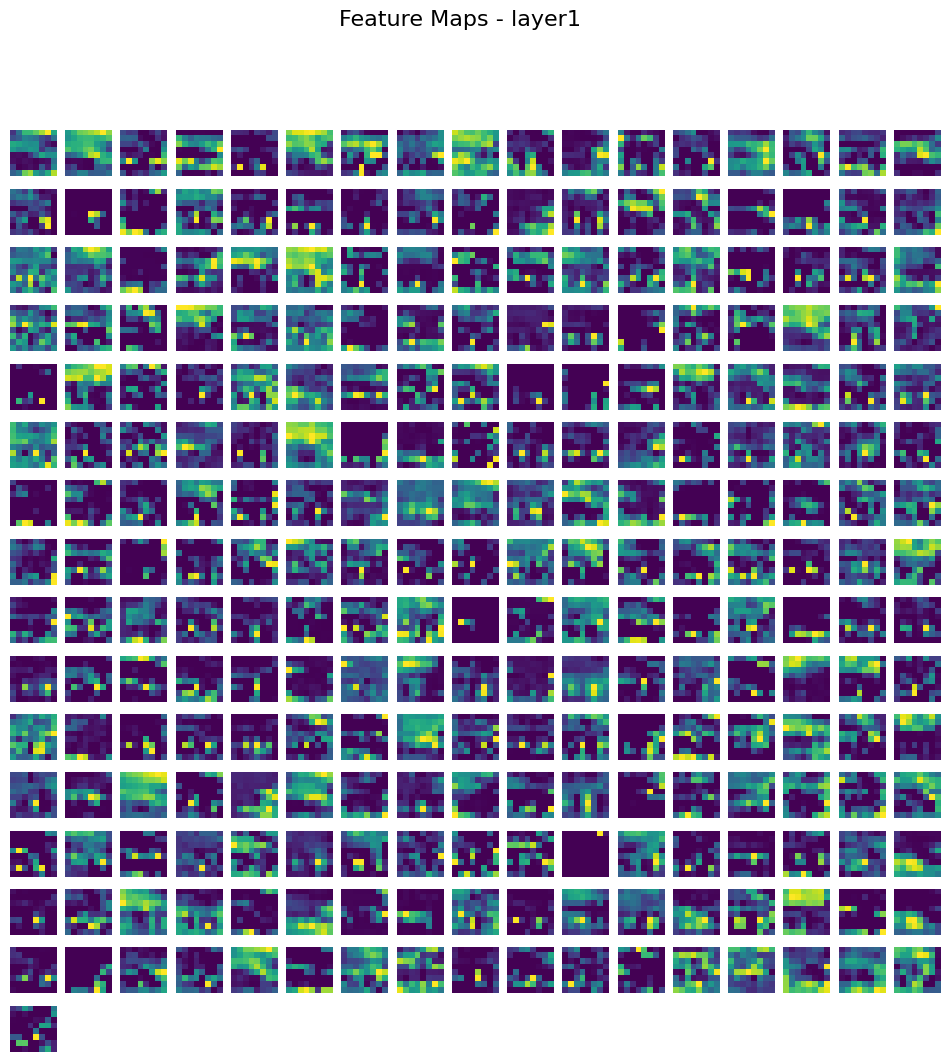

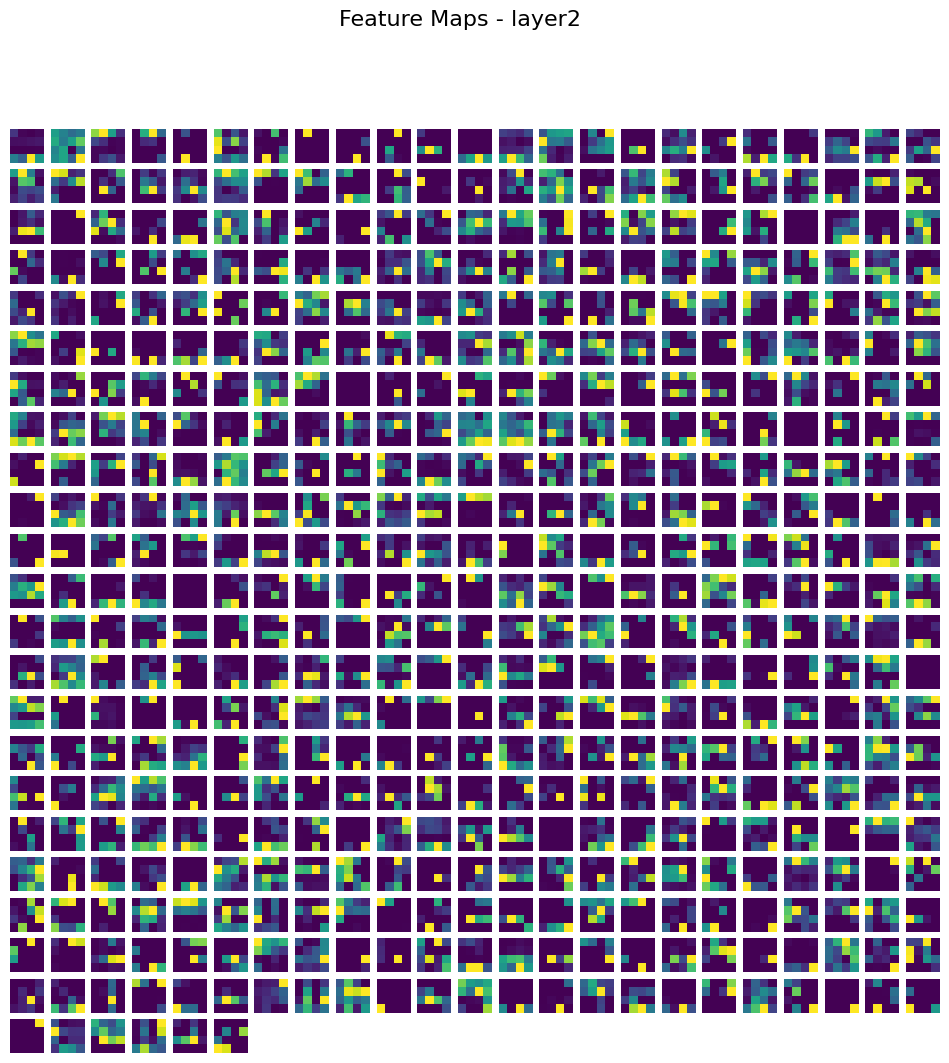

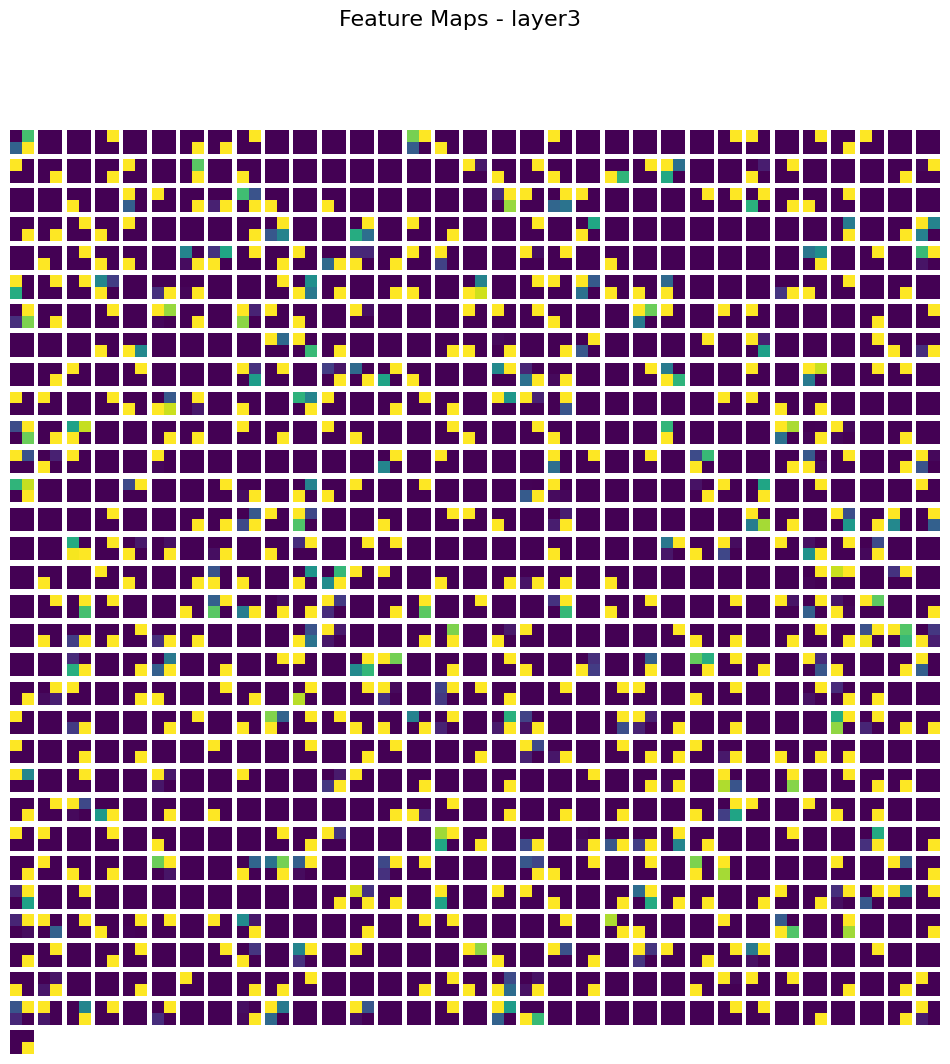

Visualizing feature maps for class: Airplane


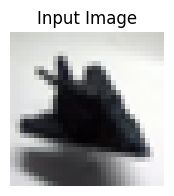

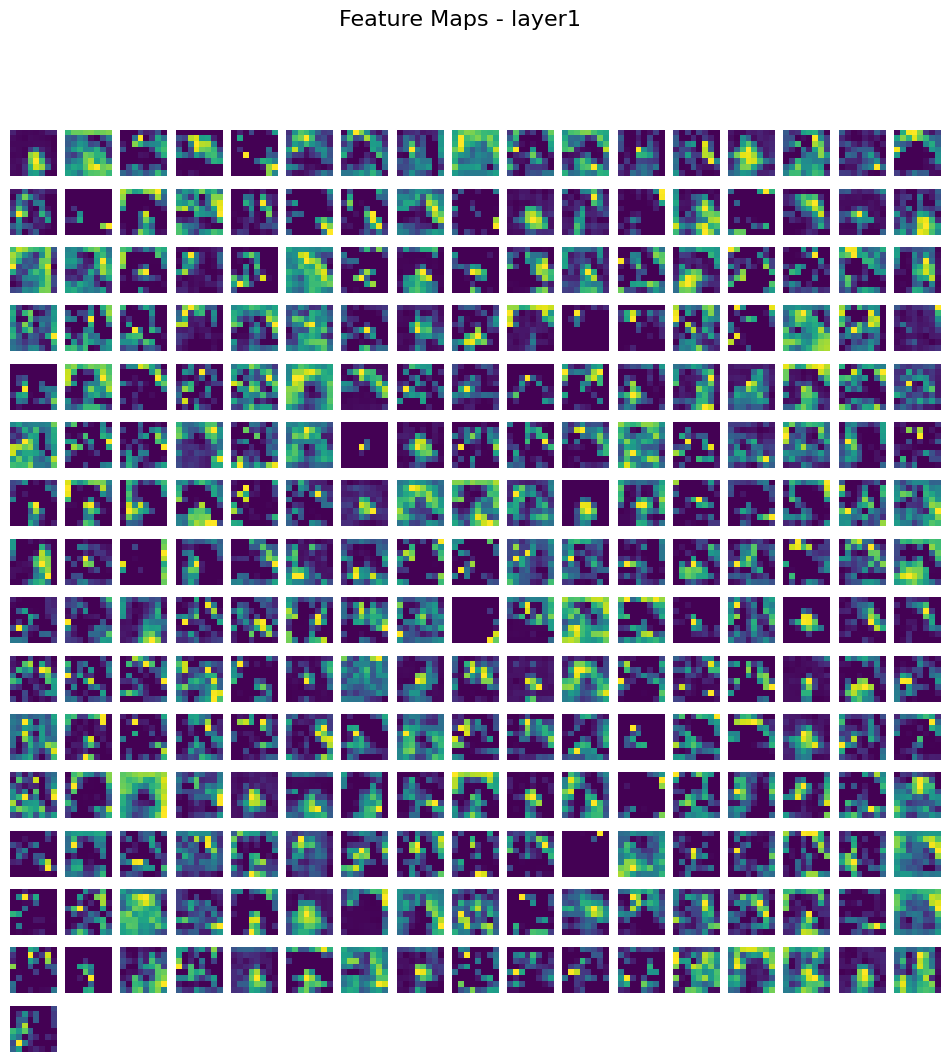

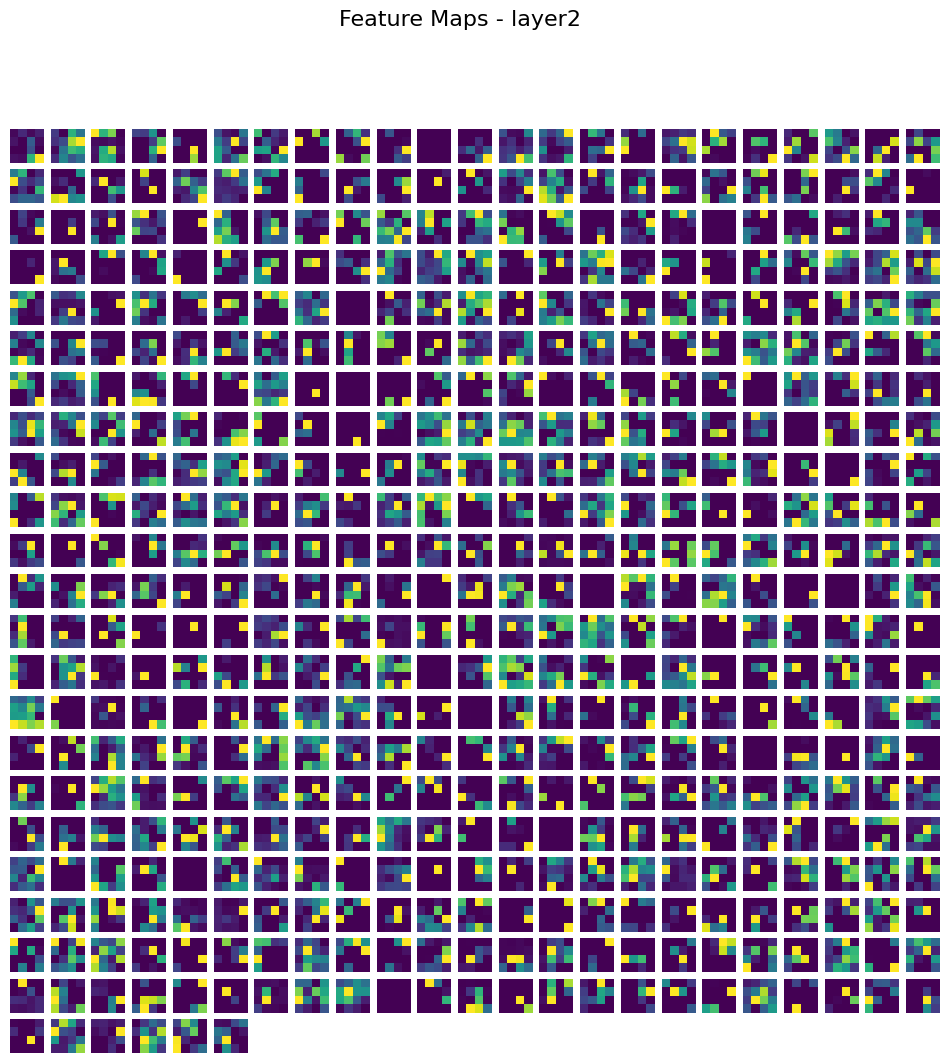

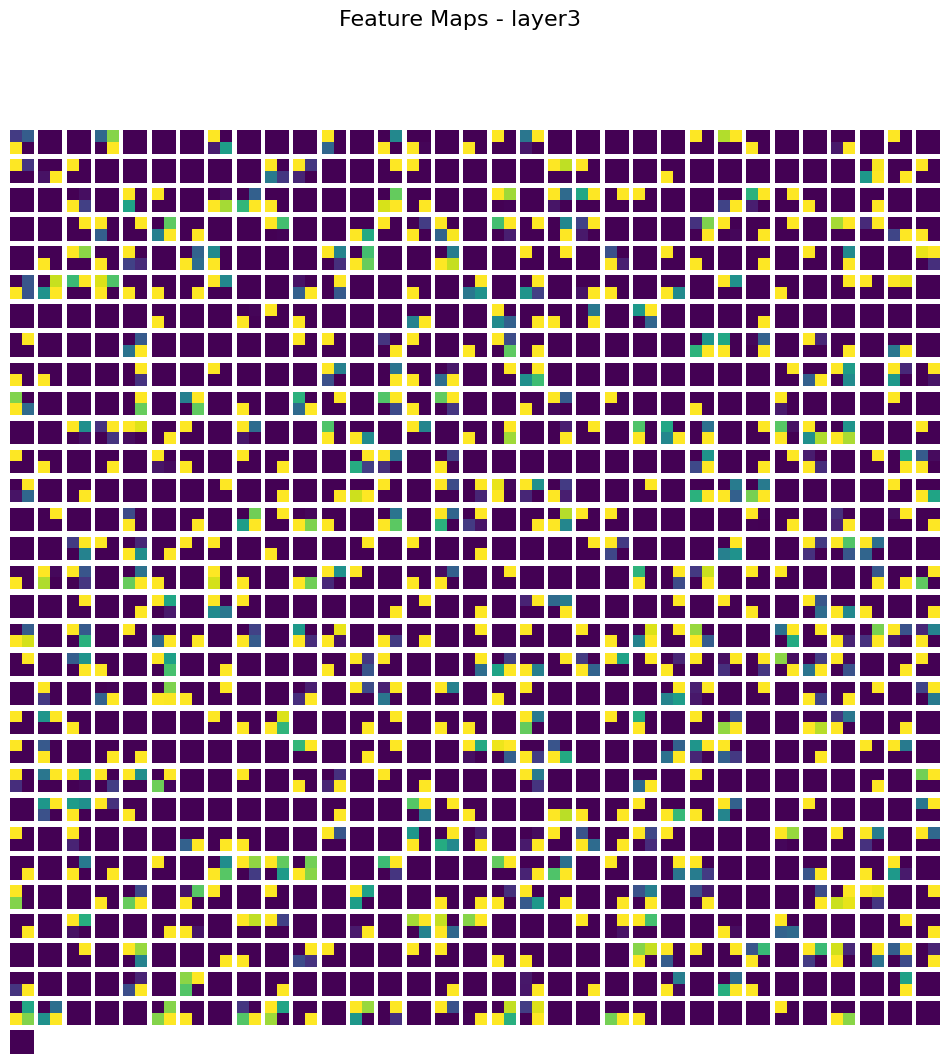

In [12]:
sample_images = get_sample_images(train_dataset, class_mapping)

layers_to_visualize = ['layer1', 'layer2', 'layer3']

for label, image in sample_images.items():
    class_name = 'Airplane' if label == 0 else 'Automobile'
    print(f"Visualizing feature maps for class: {class_name}")
    visualize_feature_maps(model, layers_to_visualize, image)

In [47]:
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]

        while True:
            positive_index = torch.randint(0, len(self.dataset), (1,)).item()
            positive_img, positive_label = self.dataset[positive_index]
            if positive_label == anchor_label and positive_index != index:
                break

        while True:
            negative_index = torch.randint(0, len(self.dataset), (1,)).item()
            negative_img, negative_label = self.dataset[negative_index]
            if negative_label != anchor_label:
                break

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.dataset)


In [77]:
class ResNetEmbedding(nn.Module):
    def __init__(self, base_model, embedding_dim=128):
        super(ResNetEmbedding, self).__init__()
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  
        self.embedding_layer = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, embedding_dim)
        )

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features
        x = torch.flatten(x, 1)       # Flatten features into a vector
        x = self.embedding_layer(x)   # Compute embeddings
        x = normalize(x, p=2, dim=1)  # Normalize embeddings to unit length
        return x

In [50]:
def train_and_validate_triplet_model(
    model, train_loader, val_loader, optimizer, criterion, num_epochs, device, best_model_path
):

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = criterion(anchor_out, positive_out, negative_out)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                anchor_out = model(anchor)
                positive_out = model(positive)
                negative_out = model(negative)

                loss = criterion(anchor_out, positive_out, negative_out)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")

        print(f"Epoch [{epoch + 1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


In [52]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transform)

def filter_classes(dataset, class_map):
    """
    Filter the dataset to only include specified classes.
    Args:
        dataset: CIFAR-10 dataset
        class_map: Dictionary mapping old class indices to new ones
    """
    filtered_indices = [i for i, label in enumerate(dataset.targets) if label in class_map]
    dataset.data = dataset.data[filtered_indices]
    dataset.targets = [class_map[label] for label in dataset.targets if label in class_map]

class_mapping = {0: 0, 1: 1}

filter_classes(train_dataset, class_mapping)
filter_classes(test_dataset, class_mapping)

validation_split = 0.2
train_size = int(len(train_dataset) * (1 - validation_split))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_triplet_dataset = TripletDataset(train_subset)
val_triplet_dataset = TripletDataset(val_subset)

batch_size = 32
train_loader = DataLoader(train_triplet_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_triplet_dataset)}")
print(f"Validation dataset size: {len(val_triplet_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 8000
Validation dataset size: 2000
Test dataset size: 2000


In [55]:
embedding_dim = 128
base_model = models.resnet50(pretrained=True)
model = ResNetEmbedding(base_model, embedding_dim)
model = model.to(device)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 10
train_losses, val_losses = train_and_validate_triplet_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    best_model_path="Best_Triplet_Model.pth"
)

Best model saved with validation loss: 0.3891
Epoch [1/10] | Train Loss: 0.4940 | Val Loss: 0.3891
Best model saved with validation loss: 0.2439
Epoch [2/10] | Train Loss: 0.3943 | Val Loss: 0.2439
Best model saved with validation loss: 0.1807
Epoch [3/10] | Train Loss: 0.2104 | Val Loss: 0.1807
Epoch [4/10] | Train Loss: 0.1790 | Val Loss: 0.2278
Best model saved with validation loss: 0.1532
Epoch [5/10] | Train Loss: 0.1335 | Val Loss: 0.1532
Best model saved with validation loss: 0.1153
Epoch [6/10] | Train Loss: 0.0998 | Val Loss: 0.1153
Epoch [7/10] | Train Loss: 0.0679 | Val Loss: 0.1623
Epoch [8/10] | Train Loss: 0.0952 | Val Loss: 0.1409
Epoch [9/10] | Train Loss: 0.0688 | Val Loss: 0.1466
Epoch [10/10] | Train Loss: 0.1537 | Val Loss: 0.2332


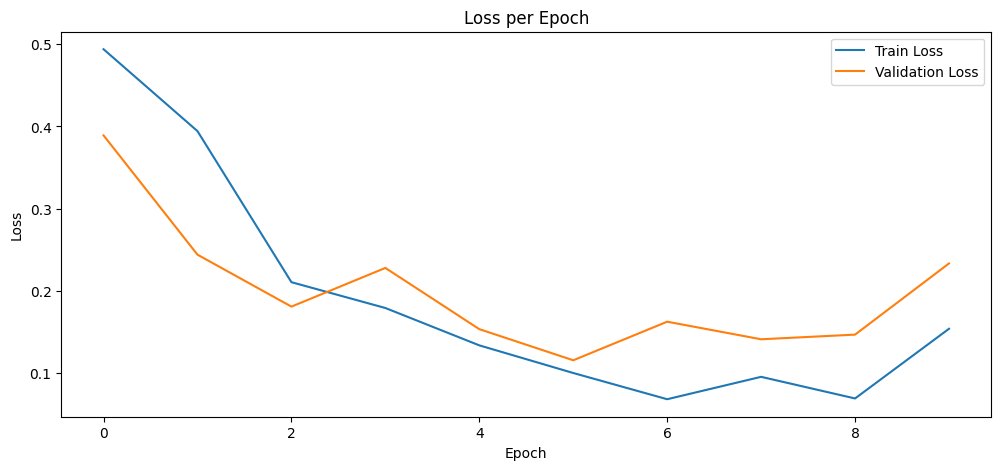

In [57]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [69]:
# Freeze feature extractor parameters
for param in model.feature_extractor.parameters():
    param.requires_grad = False

# Check the output feature size from the feature extractor
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Example input for CIFAR-10 images
dummy_features = model.feature_extractor(dummy_input)
feature_dim = dummy_features.view(dummy_features.size(0), -1).size(1)  # Flattened feature size

# Add a fully connected layer for classification
fc_layer = nn.Sequential(
    nn.Linear(feature_dim, 512),  # Match feature_dim to the output of the feature extractor
    nn.ReLU(),
    nn.Linear(512, 2)  # Output layer for 2 classes (airplane and automobile)
)
fc_layer = fc_layer.to(device)

# Define Cross-Entropy Loss and optimizer for the fully connected layer
ce_criterion = nn.CrossEntropyLoss()
ce_optimizer = optim.Adam(fc_layer.parameters(), lr=0.001)

# Update DataLoader to use labeled data for classification
classification_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
classification_val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0  # Track the best validation accuracy

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.eval()  # Keep the feature extractor frozen
    fc_layer.train()  # Train only the fully connected layer

    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in classification_train_loader:
        images, labels = images.to(device), labels.to(device)

        # Extract features using the frozen feature extractor
        with torch.no_grad():
            features = model.feature_extractor(images)
            features = features.view(features.size(0), -1)  # Flatten feature map

        # Forward pass through the fully connected layer
        outputs = fc_layer(features)

        # Compute loss and update the fully connected layer
        loss = ce_criterion(outputs, labels)
        ce_optimizer.zero_grad()
        loss.backward()
        ce_optimizer.step()

        epoch_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Average training loss and accuracy
    epoch_train_loss /= len(classification_train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    fc_layer.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in classification_val_loader:
            images, labels = images.to(device), labels.to(device)

            # Extract features and compute outputs
            features = model.feature_extractor(images)
            features = features.view(features.size(0), -1)  # Flatten feature map
            outputs = fc_layer(features)

            # Compute validation loss
            loss = ce_criterion(outputs, labels)
            epoch_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy
    epoch_val_loss /= len(classification_val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(fc_layer.state_dict(), "Best_Triplet_with_FC_Model.pth")
        print(f"Saved best model with Val Accuracy: {best_val_accuracy:.4f}")

# Save the final trained model
torch.save(fc_layer.state_dict(), "Final_Triplet_with_FC_Model.pth")
print("Final model saved as 'Final_Triplet_with_FC_Model.pth'")


Epoch [1/10] - Train Loss: 0.1229, Train Accuracy: 0.9581, Val Loss: 0.1737, Val Accuracy: 0.9325
Saved best model with Val Accuracy: 0.9325
Epoch [2/10] - Train Loss: 0.1123, Train Accuracy: 0.9623, Val Loss: 0.1759, Val Accuracy: 0.9330
Saved best model with Val Accuracy: 0.9330
Epoch [3/10] - Train Loss: 0.1098, Train Accuracy: 0.9629, Val Loss: 0.1772, Val Accuracy: 0.9320
Epoch [4/10] - Train Loss: 0.1100, Train Accuracy: 0.9625, Val Loss: 0.1790, Val Accuracy: 0.9330
Epoch [5/10] - Train Loss: 0.1082, Train Accuracy: 0.9614, Val Loss: 0.1676, Val Accuracy: 0.9340
Saved best model with Val Accuracy: 0.9340
Epoch [6/10] - Train Loss: 0.1081, Train Accuracy: 0.9626, Val Loss: 0.1744, Val Accuracy: 0.9330
Epoch [7/10] - Train Loss: 0.1088, Train Accuracy: 0.9630, Val Loss: 0.1665, Val Accuracy: 0.9330
Epoch [8/10] - Train Loss: 0.1105, Train Accuracy: 0.9620, Val Loss: 0.1708, Val Accuracy: 0.9315
Epoch [9/10] - Train Loss: 0.1070, Train Accuracy: 0.9630, Val Loss: 0.1789, Val Accura

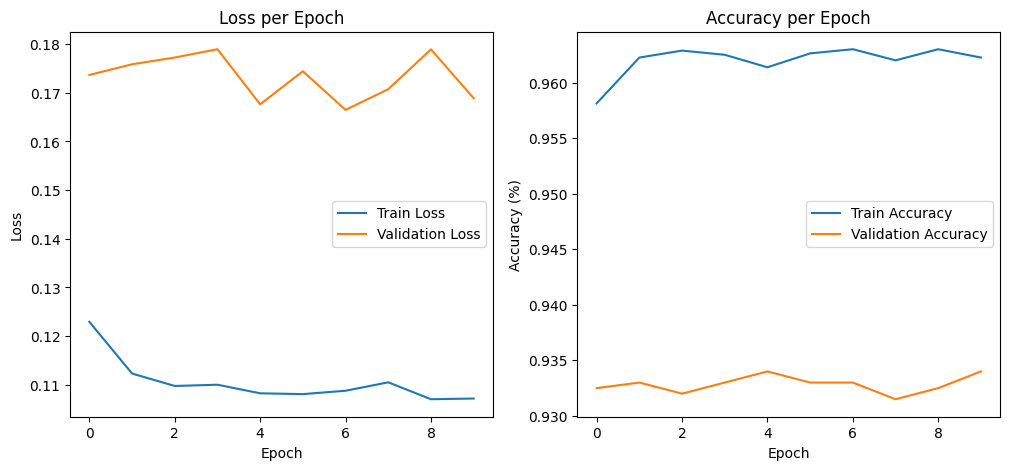

In [70]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

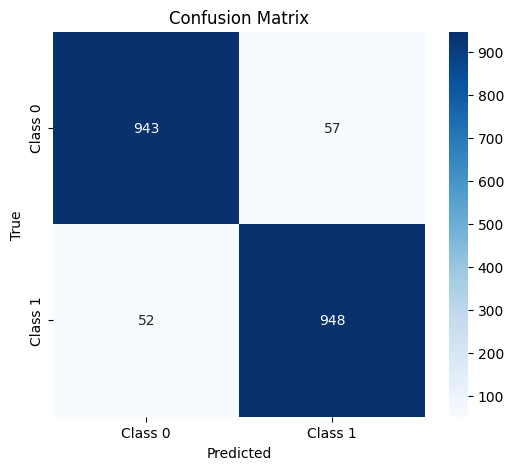

Test Accuracy: 94.55%


In [72]:
model.feature_extractor.eval()
fc_layer.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        features = model.feature_extractor(images)
        features = features.view(features.size(0), -1)  
        
        outputs = fc_layer(features)

        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = np.mean(all_preds == all_labels)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print test accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Visualizing feature maps for class: Automobile


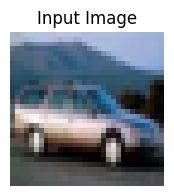

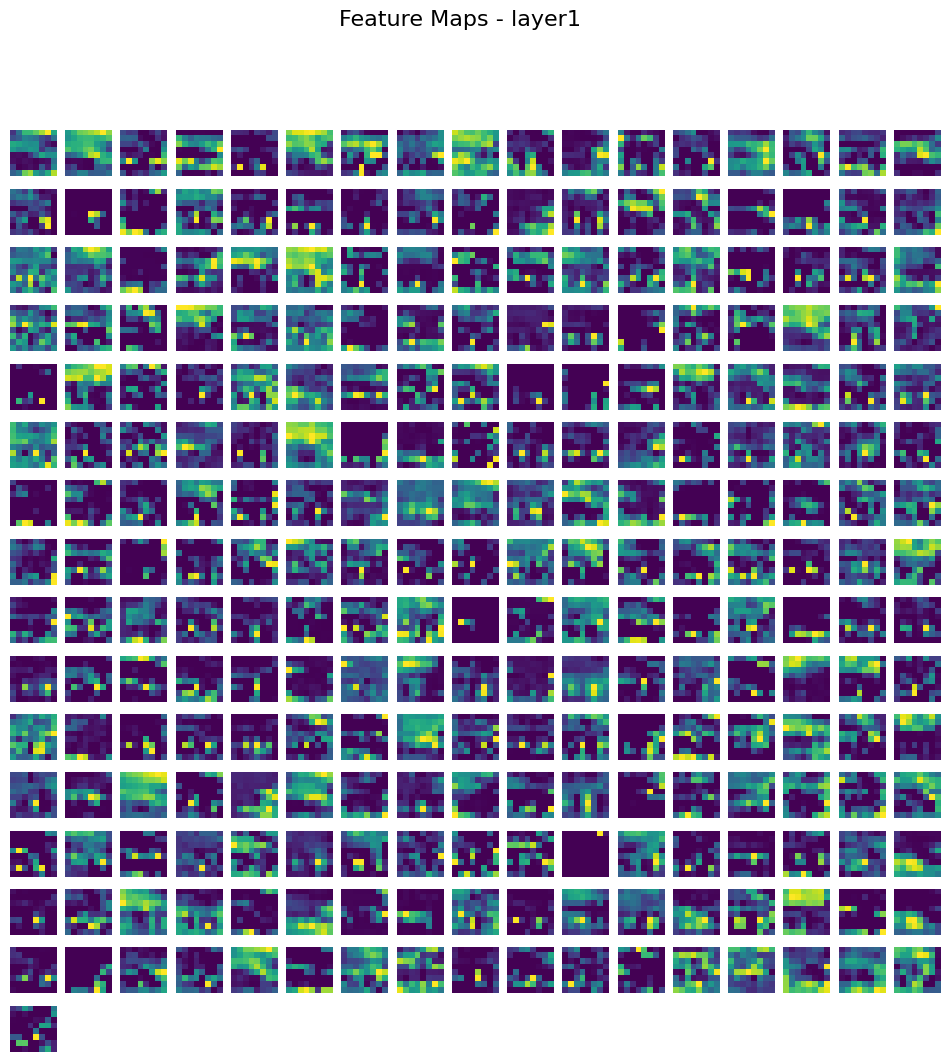

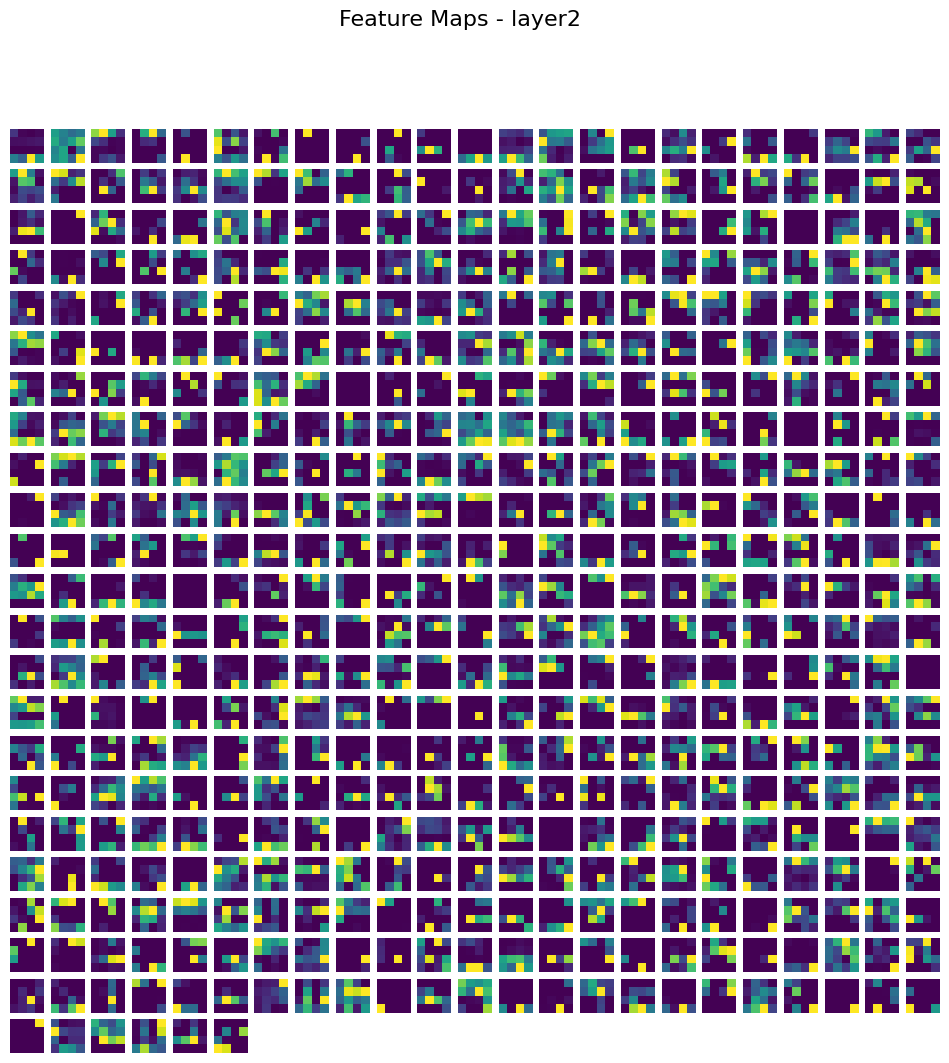

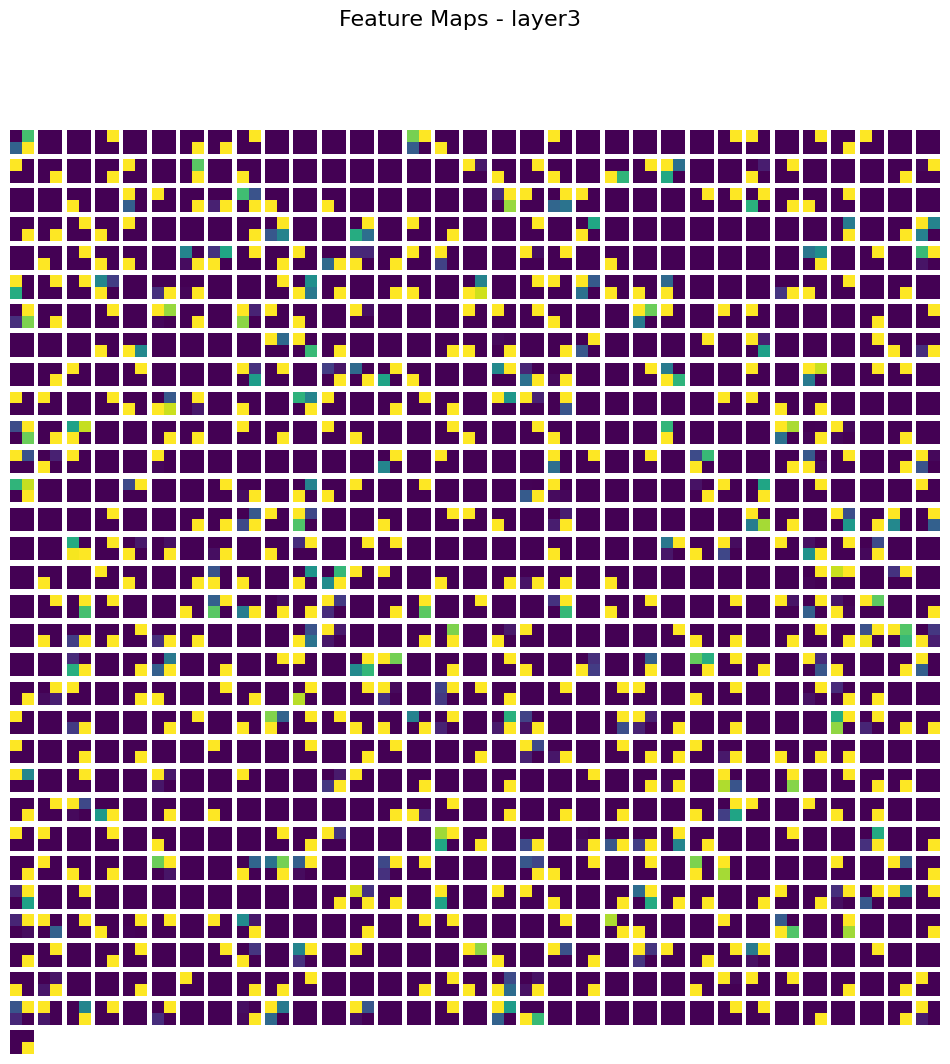

Visualizing feature maps for class: Airplane


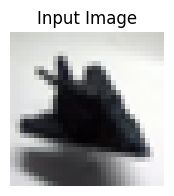

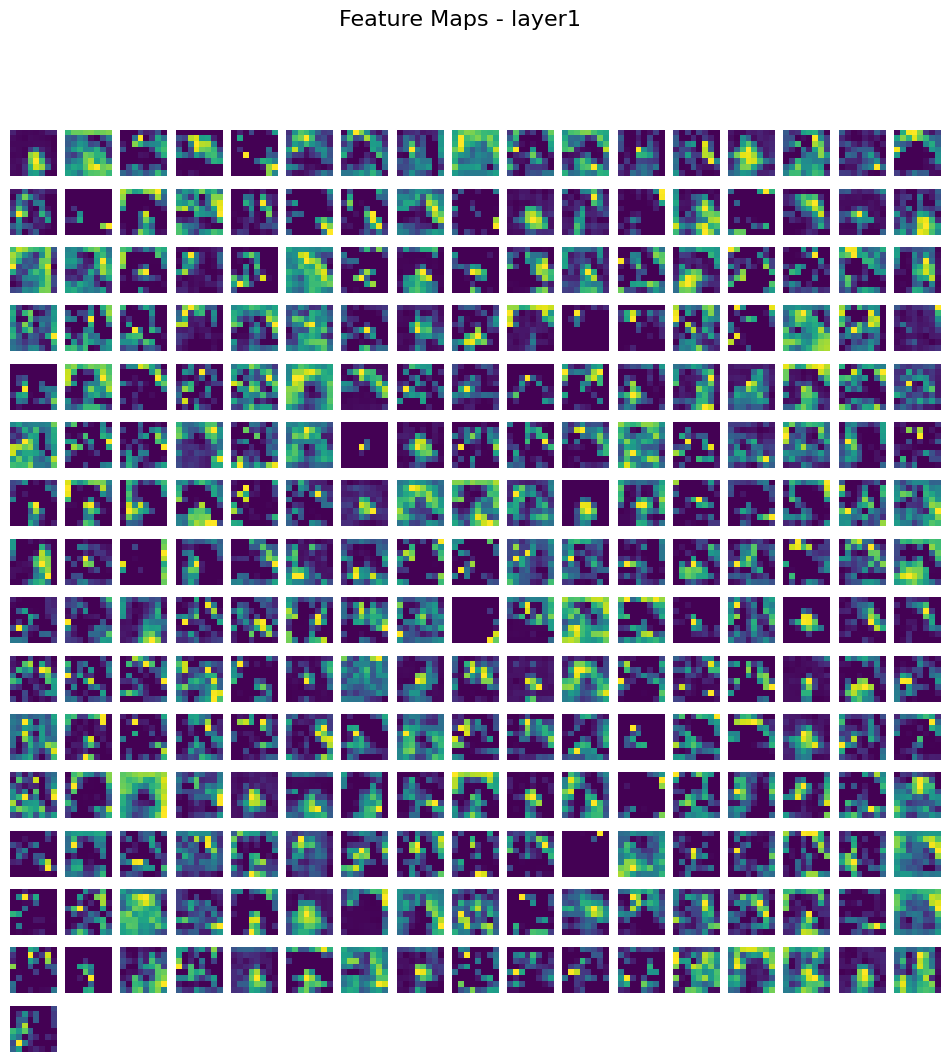

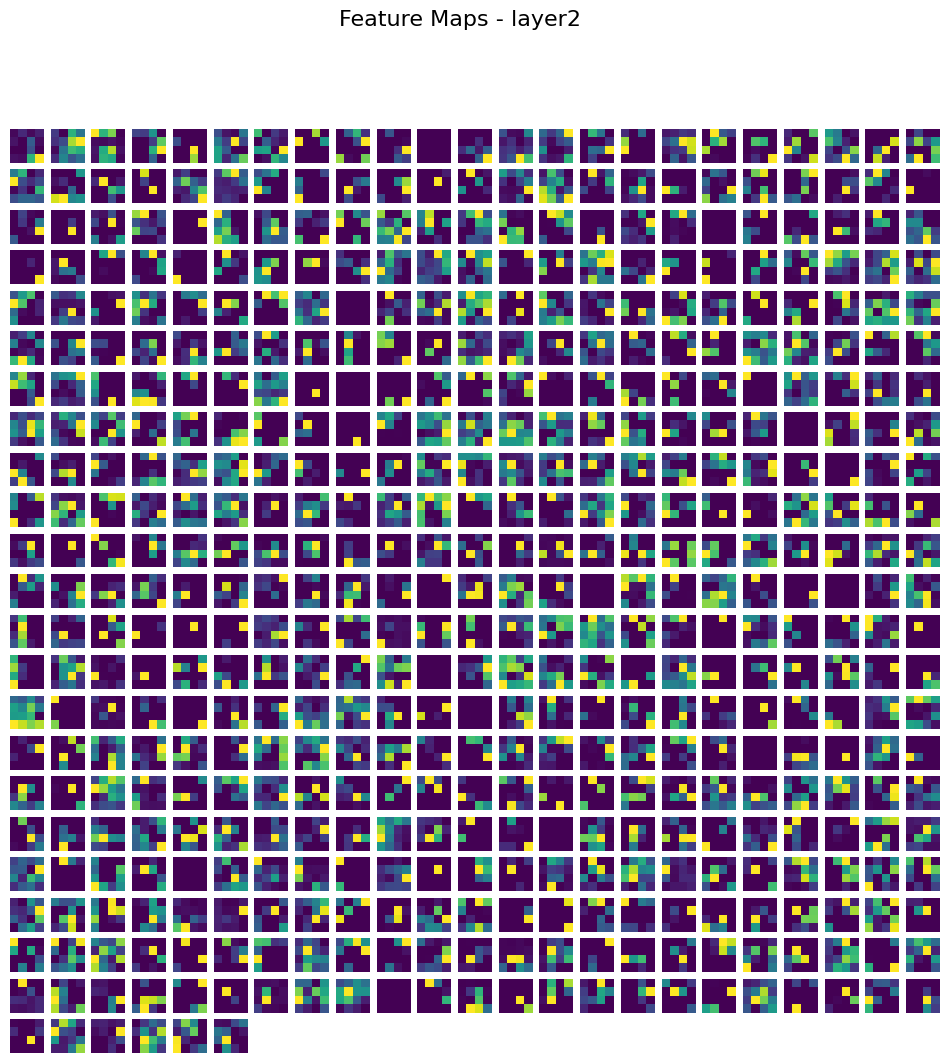

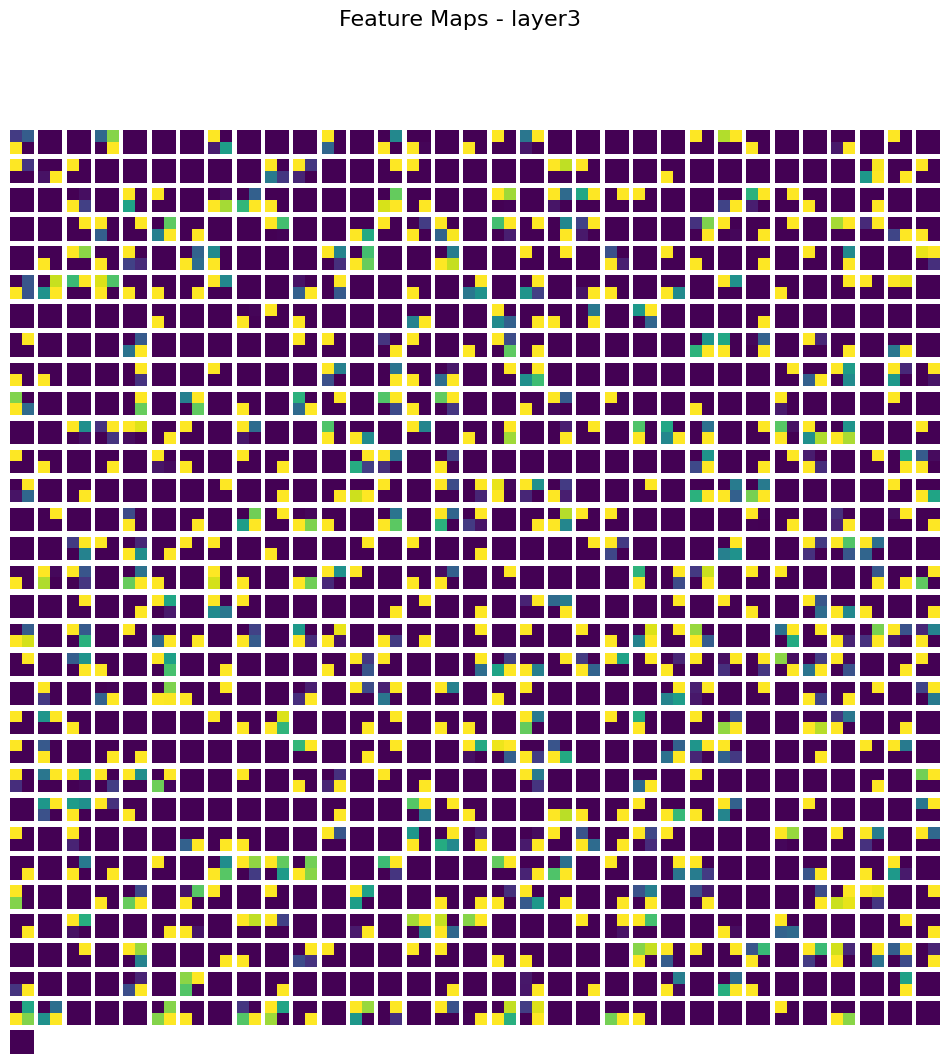

In [14]:
model = model.to(device)

sample_images = get_sample_images(train_dataset, class_mapping)

layers_to_visualize = ['layer1', 'layer2', 'layer3']

for label, image in sample_images.items():
    class_name = 'Airplane' if label == 0 else 'Automobile'
    print(f"Visualizing feature maps for class: {class_name}")
    visualize_feature_maps(model, layers_to_visualize, image)

### Feature Map Comparison Across Layers

1. **Layer 1**:
   - Captures **low-level features**: edges, textures, and basic shapes.
   - Feature maps are **dense** and structured, preserving fine details.

2. **Layer 2**:
   - Extracts **mid-level features**: patterns and object parts.
   - Activations are **denser** than layer1 but less fine-grained.

3. **Layer 3**:
   - Focuses on **high-level features**: abstract representations for objects.
   - Feature maps are **sparser**, highlighting specific discriminative regions.


- **Layer 1**: Fine details and textures.  
- **Layer 2**: Object parts and patterns.  
- **Layer 3**: Abstract, global features.

### Feature Map Quality
- **Cross-Entropy Loss**:
  - Early layers detect basic edges and textures, while deeper layers capture complex patterns.
  - Feature maps are **dense and well-structured**, focusing on discriminative features for classification.

- **Triplet Loss**:
  - Feature maps are **sparser**, especially in deeper layers, highlighting unique and invariant features.
  - This sparsity improves generalization for tasks like **retrieval** or **clustering**.

---

### Final Model Accuracy on Test Data
- **Cross-Entropy Loss**:
  - Achieved **97.35%** slightly outperforming triplet-loss-entropy.
  - Effective for **direct classification**, optimizing class separation.

- **Triplet Loss**:
  - Achieved **94.55% accuracy** 
  - Demonstrates strong generalization by learning robust embeddings.

---

### Convergence Speed
- **Cross-Entropy Loss**:
  - Converges quickly, with sharp loss reduction in the first **3 epochs**.
  - Minor fluctuations after epoch 7 suggest slight overfitting.

- **Triplet Loss**:
  - Convergence is **smoother** with a steady decline in loss over 10 epochs.
  - Learning is stable, with less sensitivity to overfitting.

---

### Generalization Capability
- **Cross-Entropy Loss**:
  - Effective for **classification tasks** with well-separated classes.
  - Features may not generalize well to new tasks or domains.

- **Triplet Loss**:
  - Produces embeddings ideal for **retrieval**, **clustering**, and handling **new classes** without retraining.
  - Features are robust to intra-class variations, improving adaptability.

In [ ]:
def filter_classes(dataset, classes):
    indices = [i for i, label in enumerate(dataset.targets) if label in classes]
    dataset.data = dataset.data[indices]
    dataset.targets = [dataset.targets[i] for i in indices]
    return dataset

class TripletCIFAR10(Dataset):
    def __init__(self, dataset, classes, transform=None):
        self.transform = transform
        self.classes = classes

        self.data = []
        self.targets = []
        for idx, (img, label) in enumerate(zip(dataset.data, dataset.targets)):
            if label in classes:
                self.data.append(img)
                self.targets.append(classes.index(label))

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)
        self.label_to_indices = {label: np.where(self.targets == label)[0] for label in set(self.targets)}

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        anchor_img = self.data[idx]
        anchor_label = self.targets[idx]

        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        positive_img = self.data[positive_idx]

        negative_label = (anchor_label + 1) % 2
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_img = self.data[negative_idx]

        anchor_img = Image.fromarray(anchor_img)
        positive_img = Image.fromarray(positive_img)
        negative_img = Image.fromarray(negative_img)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return (anchor_img, positive_img, negative_img), []

class CombinedLossModel(nn.Module):
    def __init__(self):
        super(CombinedLossModel, self).__init__()
        self.feature_extractor = models.resnet50(pretrained=True)
        self.feature_extractor.fc = nn.Identity()
        self.classifier = nn.Linear(2048, 2)

    def forward(self, x):
        features = self.feature_extractor(x)
        classification_output = self.classifier(features)
        return features, classification_output

def train_combined_model(model, triplet_loader, classification_loader, criterion_triplet, criterion_cross_entropy, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        triplet_iter = iter(triplet_loader)
        classification_iter = iter(classification_loader)

        for _ in range(min(len(triplet_loader), len(classification_loader))):
            (anchor, positive, negative), _ = next(triplet_iter)
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            inputs, labels = next(classification_iter)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            anchor_out, _ = model(anchor)
            positive_out, _ = model(positive)
            negative_out, _ = model(negative)

            _, classification_output = model(inputs)

            loss_triplet = criterion_triplet(anchor_out, positive_out, negative_out)
            loss_cross_entropy = criterion_cross_entropy(classification_output, labels)
            loss_total = loss_triplet + loss_cross_entropy

            loss_total.backward()
            optimizer.step()

            epoch_loss += loss_total.item()
            _, preds = torch.max(classification_output, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        epoch_loss /= len(classification_loader)
        accuracy = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, train_accuracies

def plot_training_metrics(losses, accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Training Accuracy', marker='s')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


Epoch 1/10, Loss: 0.5036, Accuracy: 0.9333
Epoch 2/10, Loss: 0.1659, Accuracy: 0.9747
Epoch 3/10, Loss: 0.1167, Accuracy: 0.9816
Epoch 4/10, Loss: 0.0658, Accuracy: 0.9902
Epoch 5/10, Loss: 0.0684, Accuracy: 0.9891
Epoch 6/10, Loss: 0.0550, Accuracy: 0.9909
Epoch 7/10, Loss: 0.0459, Accuracy: 0.9911
Epoch 8/10, Loss: 0.0496, Accuracy: 0.9921
Epoch 9/10, Loss: 0.0379, Accuracy: 0.9920
Epoch 10/10, Loss: 0.0377, Accuracy: 0.9922


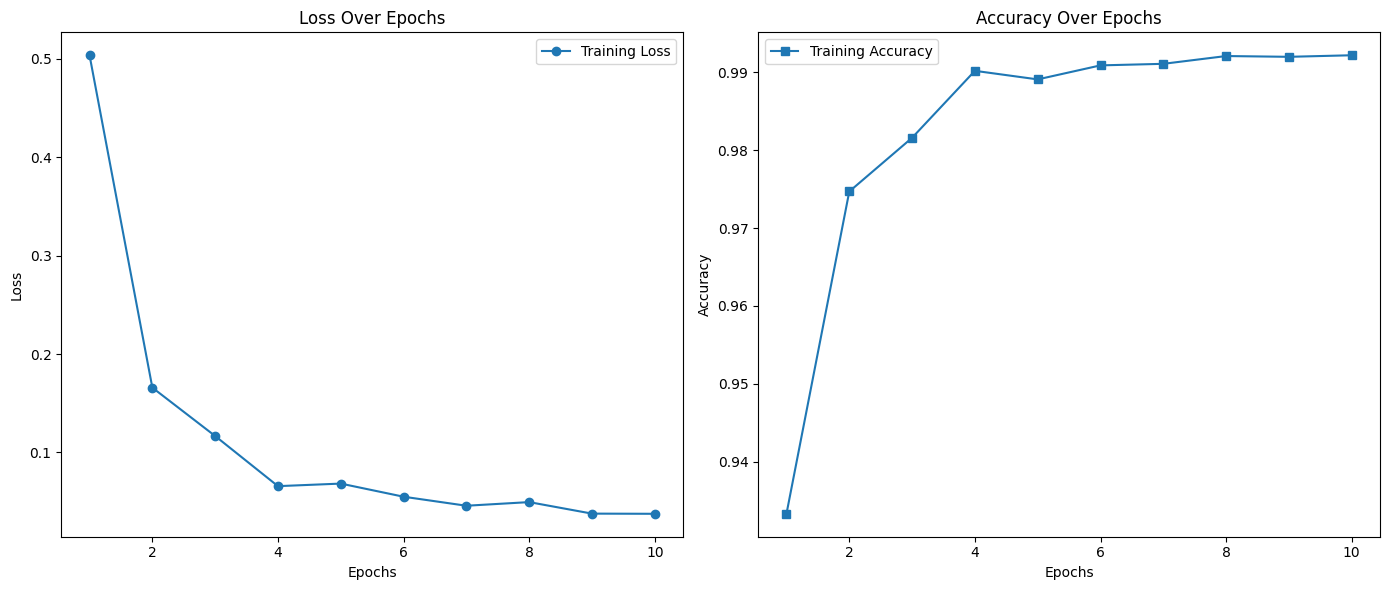

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset_full = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_dataset_full = filter_classes(train_dataset_full, [0, 1])
test_dataset_full = filter_classes(test_dataset_full, [0, 1])

train_dataset_full.targets = torch.tensor(train_dataset_full.targets)
test_dataset_full.targets = torch.tensor(test_dataset_full.targets)


combined_model = CombinedLossModel().to(device)
triplet_criterion = nn.TripletMarginLoss(margin=1.0)
cross_entropy_criterion = nn.CrossEntropyLoss()
optimizer_combined = optim.Adam(combined_model.parameters(), lr=0.001)

train_triplet_dataset = TripletCIFAR10(train_dataset_full, [0, 1], transform=transform)
train_triplet_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset_full, batch_size=32, shuffle=True)

losses, accuracies = train_combined_model(
    combined_model, 
    triplet_loader=train_triplet_loader,
    classification_loader=train_loader,
    criterion_triplet=triplet_criterion,
    criterion_cross_entropy=cross_entropy_criterion,
    optimizer=optimizer_combined,
    num_epochs=10
)

plot_training_metrics(losses, accuracies, len(losses))

In [11]:
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
filter_classes(test_dataset , [0, 1])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


Test Accuracy: 98.43%


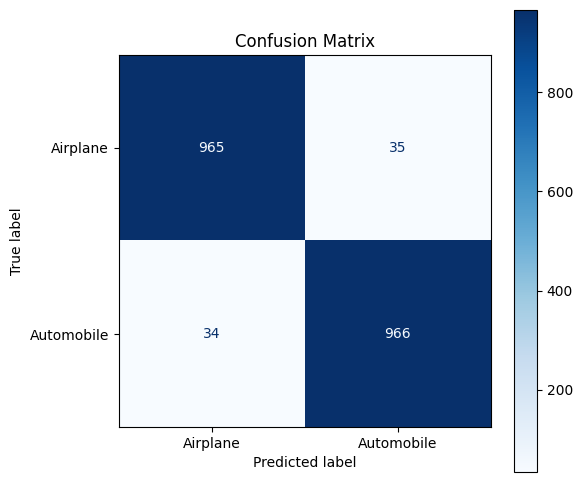

In [33]:
class_names = ["Airplane", "Automobile"]  
predictions, true_labels = evaluate_model(combined_model, test_loader, device)

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

plot_confusion_matrix(true_labels, predictions, class_names)

### 1. Effect of Combining Losses
- **Cross Entropy Loss**:
  - Optimizes for accurate class predictions by focusing on **class separability**.
- **Triplet Loss**:
  - Structures the embedding space to cluster similar inputs and separate dissimilar ones, improving **generalization**.

**Impact**:
- Achieves strong classification performance.
- Improves representation learning for tasks like retrieval and verification.
- Combined loss provides **slightly better overall performance** compared to using each loss individually.

---

### 2. Convergence Behavior
- **Cross Entropy**:  
  - Faster and smoother convergence as it minimizes prediction errors directly.
- **Triplet Loss**:  
  - Slower and oscillatory due to the complexity of learning embeddings.

**Combined Effect**:
- The convergence rate depends on loss weighting:
  - Higher **Cross Entropy** weight → Faster convergence, weaker embeddings.
  - Higher **Triplet Loss** weight → Slower convergence, better embedding quality.
- Balanced weighting allows reasonable convergence while achieving both goals.

---

### 3. Generalization and Overfitting
- **Cross Entropy Alone**:  
  - Can overfit on small or noisy datasets as it optimizes strictly for class labels.
- **Triplet Loss Alone**:  
  - Enhances generalization but may underperform in strict classification tasks.

**Combined Effect**:
- Reduces overfitting by regularizing learning with **embedding constraints** from Triplet Loss.
- Maintains high classification accuracy through **Cross Entropy Loss**.
